In [116]:
# import tensorflow
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import mglearn
from sklearn.svm import SVC
from sklearn import metrics

In [117]:
data = np.load('./data/olivetti_faces.npy')
label = np.load('./data/olivetti_faces_target.npy')
# label = np.zeros(len(data))

In [118]:
def load_data_true(img_folder):
    imgs = []
    for img in os.listdir(img_folder):
        img = cv2.imread(os.path.join(img_folder, img), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (64, 64))
        imgs.append(img)
        
    return np.array(imgs)

data_face = load_data_true('./data_true/images')
data_face2 = load_data_true('./data_true/image2')
data_face = np.concatenate((data_face, data_face2), axis=0)
# label_face = np.ones(len(data_face))
label_face = np.full(len(data_face), 40)

In [119]:
print(data_face.shape)

(618, 64, 64)


In [120]:
def normailze_data_face(data):
    data = data.astype('float64')
    data /= 255
    return data
data_face = normailze_data_face(data_face)

In [121]:
print(f'data shape: {data.shape}')
print(f'label shape: {label.shape}')
print(f'data_face shape: {data_face.shape}')
print(f'label_face shape: {label_face.shape}')

data shape: (400, 64, 64)
label shape: (400,)
data_face shape: (618, 64, 64)
label_face shape: (618,)


In [122]:
print(data[0])

[[0.30991736 0.3677686  0.41735536 ... 0.37190083 0.3305785  0.30578512]
 [0.3429752  0.40495867 0.43801653 ... 0.37190083 0.338843   0.3140496 ]
 [0.3429752  0.41735536 0.45041323 ... 0.38016528 0.338843   0.29752067]
 ...
 [0.21487603 0.20661157 0.2231405  ... 0.15289256 0.16528925 0.17355372]
 [0.20247933 0.2107438  0.2107438  ... 0.14876033 0.16115703 0.16528925]
 [0.20247933 0.20661157 0.20247933 ... 0.15289256 0.16115703 0.1570248 ]]


In [123]:
print(data_face[0])

[[0.30588235 0.40392157 0.43529412 ... 0.90980392 0.92156863 0.92156863]
 [0.37254902 0.45098039 0.41960784 ... 0.88235294 0.84313725 0.90980392]
 [0.82352941 0.79215686 0.77254902 ... 0.89411765 0.90980392 0.8627451 ]
 ...
 [0.32156863 0.32156863 0.35686275 ... 0.51372549 0.78039216 0.84313725]
 [0.16470588 0.22352941 0.29019608 ... 0.19607843 0.2745098  0.34117647]
 [0.21960784 0.23137255 0.16078431 ... 0.10588235 0.14901961 0.20784314]]


In [124]:
# concat data
data = np.concatenate((data, data_face), axis=0)
label = np.concatenate((label, label_face), axis=0)
label = label.astype(int)

In [125]:
print(f'data shape: {data.shape}')
print(f'label shape: {label.shape}')
print(f'uniques label: {np.unique(label)}')

data shape: (1018, 64, 64)
label shape: (1018,)
uniques label: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]


In [126]:
# X = data.reshape((data.shape[0], data.shape[1]*data.shape[2]))
# print('X shape:', X.shape)
X = data.reshape((data.shape[0], data.shape[1],data.shape[2],1))
print('X shape:', X.shape)

X shape: (1018, 64, 64, 1)


In [127]:
x_train, x_test, y_train, y_test = train_test_split(X, label, test_size=0.2,stratify=label, random_state=42,shuffle=True)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (814, 64, 64, 1)
x_test shape: (204, 64, 64, 1)


In [128]:
print('class: ',len(np.unique(y_train)))

class:  41


<Axes: title={'center': 'Number of Samples for Each Classes'}, xlabel='subject ids'>

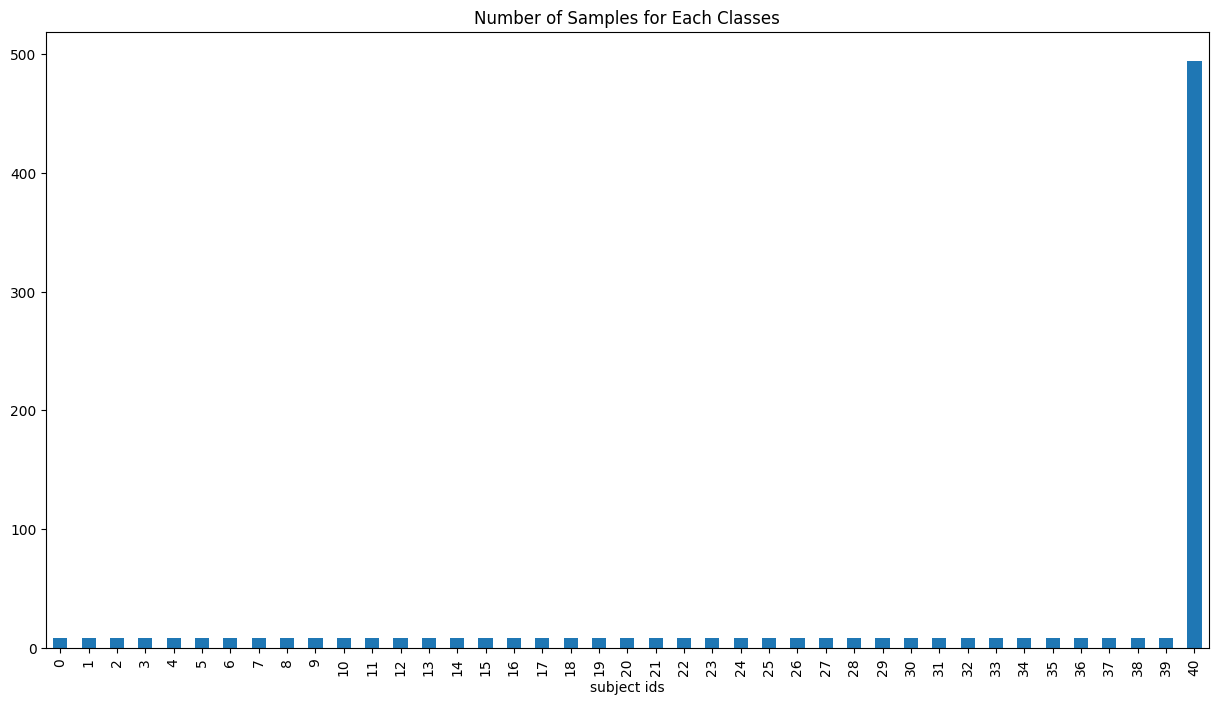

In [129]:
y_frame=pd.DataFrame()
y_frame['subject ids']= y_train
y_frame.groupby(['subject ids']).size().plot.bar(figsize=(15,8),title="Number of Samples for Each Classes")

In [130]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_base_nerwork(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    return Model(inputs, x)
    
def triplet_loss(inputs, dist='euclidean', margin='maxplus'):
    anchor, positive, negative = inputs
    positive_distance = tf.square(anchor - positive)
    negative_distance = tf.square(anchor - negative)
    """_summary_
        distance between two vectors
    Example:
    v=(1,0,5)
    w=(0,2,4)
    => d(v,w)=sqrt((1-0)^2+(0-2)^2+(5-4)^2=sqrt(1^2+(-2)^2+1^2)=sqrt(1+4+1)=√6
    """
    if dist == 'euclidean':
        positive_distance = tf.sqrt(tf.reduce_sum(positive_distance, axis=-1, keepdims=True))
        negative_distance = tf.sqrt(tf.reduce_sum(negative_distance, axis=-1, keepdims=True))
    elif dist == 'sqeuclidean':
        positive_distance = tf.reduce_sum(positive_distance, axis=-1, keepdims=True)
        negative_distance = tf.reduce_sum(negative_distance, axis=-1, keepdims=True)
    loss = positive_distance - negative_distance
    if margin == 'maxplus':
        loss = tf.maximum(0.0, 2 + loss)
    elif margin == 'softplus':
        loss = tf.log(1 + tf.exp(loss))
    return tf.reduce_mean(loss)

def create_siamese_network(input_shape, base_network):
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    input_c = Input(shape=input_shape)
    
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)
    processed_c = base_network(input_c)
    
    distance = triplet_loss([processed_a, processed_b, processed_c])
    network = Model([input_a, input_b, input_c], distance)
    return network

input_shape = (64, 64, 1)
base_network = create_base_nerwork(input_shape)
siamese_network = create_siamese_network(input_shape, base_network)
siamese_network.compile(loss='mse', optimizer='adam')
siamese_network.summary()


Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 input_23 (InputLayer)          [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 model_10 (Functional)          (None, 128)          682624      ['input_22[0][0]',               
                                                                  'input_23[0][0]',        

In [131]:
def prepare_data_for_siamese(x_train, y_train):
    triplets = []
    num_classes = len(np.unique(y_train))
    for _ in range(num_classes):
        # select anchor
        anchor_class = np.random.randint(0, num_classes)
        negative_class = anchor_class
        
        # select double
        indices = np.where(y_train == anchor_class)[0]
        anchor_idx = np.random.choice(indices)
        positive_idx = np.random.choice(indices)
        while positive_idx == anchor_idx:
            positive_idx = np.random.choice(indices)
        
        while negative_class == anchor_idx:
            negative_class = np.random.randint(0, num_classes)
            
        negative_indices = np.where(y_train == negative_class)[0]
        negative_idx = np.random.choice(negative_indices)
        triplets.append([x_train[anchor_idx], x_train[positive_idx], x_train[negative_idx]])
    return np.array(triplets)
    
triplets = prepare_data_for_siamese(x_train, y_train)
print('triplets shape:', triplets.shape)

triplets shape: (41, 3, 64, 64, 1)


In [132]:
siamese_network.fit([triplets[:, 0], triplets[:, 1], triplets[:, 2]], np.zeros((triplets.shape[0], 1)), batch_size=64, epochs=10)

Epoch 1/10
1/1 [==============================] - 1s 584ms/step - loss: 4.0331
Epoch 2/10
1/1 [==============================] - 0s 57ms/step - loss: nan
Epoch 3/10
1/1 [==============================] - 0s 7ms/step - loss: nan
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: nan
Epoch 5/10
1/1 [==============================] - 0s 7ms/step - loss: nan
Epoch 6/10
1/1 [==============================] - 0s 7ms/step - loss: nan
Epoch 7/10
1/1 [==============================] - 0s 7ms/step - loss: nan
Epoch 8/10
1/1 [==============================] - 0s 7ms/step - loss: nan
Epoch 9/10
1/1 [==============================] - 0s 7ms/step - loss: nan
Epoch 10/10
1/1 [==============================] - 0s 7ms/step - loss: nan
